# Final Project: Impact of Valine on Isoleucine Biosynthetic Pathway

## Overview

In week 4, we looked at the dynamics that arise from end product inhibition in biosynthetic pathways. Specifically, models were used to show how the production of L-isoleucine from L-threonine inhibits further proudction of L-isoleucine. In this notebook, we will look at the role L-Valine plays in this pathway. 

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Introduction

L-isoleucine production occurs through a multi-step biosynthetic pathway in which consequential chemical reactions occur following the deamination of L-threonine. This reaction is modeled schematically below:


$\large Thr \overset{A}{\rightleftharpoons} M_{1} \overset{B}{\rightleftharpoons} M_{2} \overset{C}{\rightleftharpoons} M_{3} \overset{D}{\rightleftharpoons} M_{4} \overset{E}{\rightleftharpoons} Ile$



 L-valine and L-isoleucine have similar biosynthetic pathways that play a role in each other's pathways. This noteook will model a simplified version of the biosynthetic pathway of L-valine and tie it back to the isoleucine biosynthetic pathway examined in week 4. 

### Umbarger's End-Product Inhibition

In the Umbarger paper [1956], we observed the end-product inhibition of L-isoleucine production by restricting the first step of the biosynthetic pathway, deamination of L-threonine. L-threonine is an isoleucine-specific enzyme, so it will only be degraded if the concentration of L-isoleucine is low. Thus, L-isoleucine inhibits it's own production by triggering the negative-feedback loop. 

Table 1 of the Umbarger paper shows L-isolecuine as the largest inhibitor of L-threonine deamination. It can also be seen in this table that L-valine does not inhibit this deamination at all. Upon further research, it's actually known that Valine reverses the inhibition of L-threonine.

### Introducing Valine to the L04 Model

The L04 notebook modeled isoleucine's biosynthetic pathway, looking specifically at how isoleucine inhibiting it's own production. Below, we will model this same pathway but with the addition of valine. The effects of valine will be integrated through the inhibitor binding parameter, K_I. 

Two different methods are used to calculate the value of the inhibition constant, K_I. The first method uses a step function, and the second method uses a sigmoid function. Plotted below are each of the results of each of these methods, depicted as a plot of valine concentration against K_I value. Below that are plots of the effects of inhibitor concentration on the reaction rate when K_I is calculated using a step function and sigmoid function, respectively. 


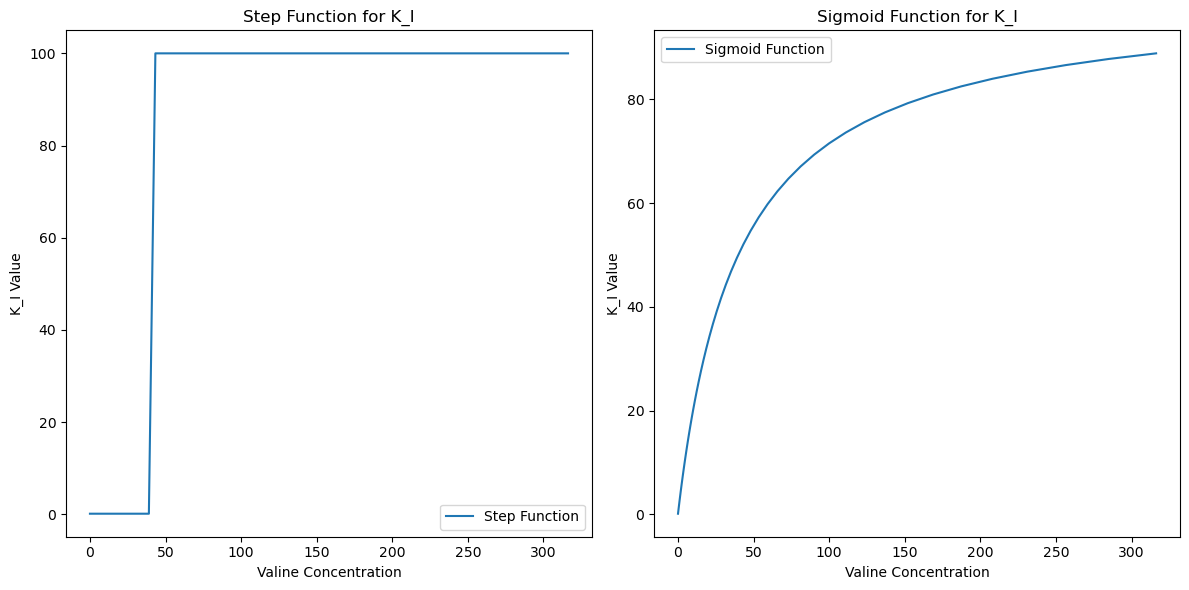

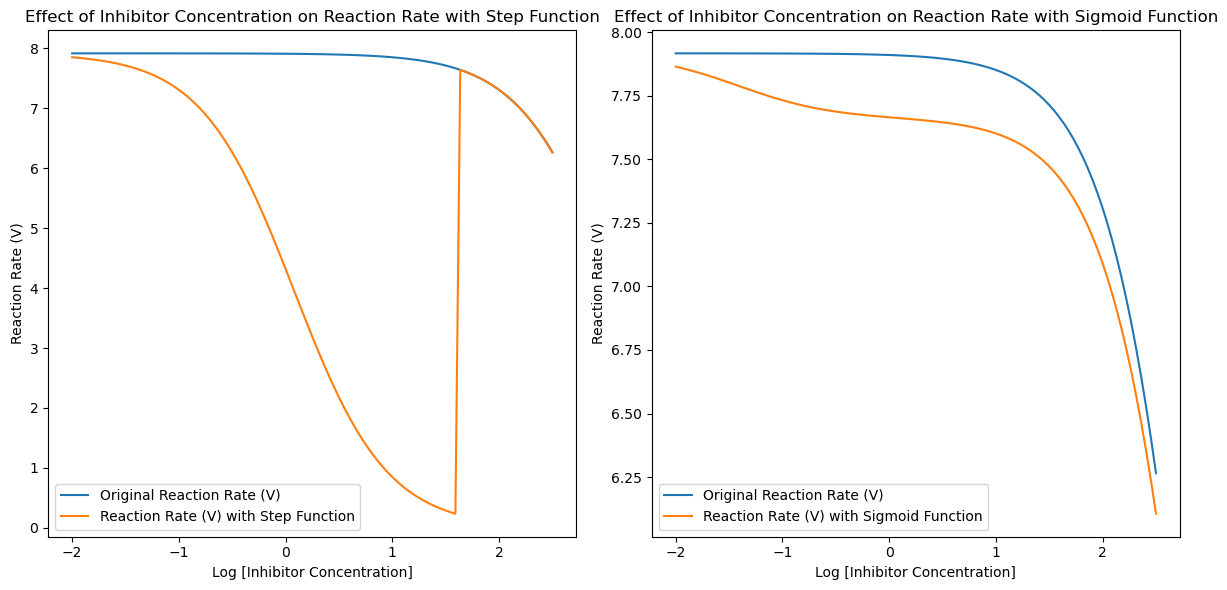

In [4]:
# Parameters
V_max_f = 10
V_max_r = 5
K_M_S = 1
K_M_P = 1
S = 10
P = 1
K_I_1 = 100
K_I_2 = 0.1
Valine = np.logspace(-2, 2.5, 100)
I_values = np.logspace(-2, 2.5, 100)  # log-spaced inhibitor concentrations
K_V = 40
n=1

# Competitive Inhibition Rate Law
V = (V_max_f / K_M_S * S - V_max_r / K_M_P * P) / (1 + S / K_M_S + P / K_M_P + I_values / K_I_1)

# Step function for K_I
K_I_step = np.where(Valine > 40, K_I_1, K_I_2)

# Sigmoid function for K_I
K_I_sigmoid = K_I_2 + (K_I_1 * Valine**n) / (K_V**n + Valine**n)

# Updated V with step function applied
V_with_step = (V_max_f / K_M_S * S - V_max_r / K_M_P * P) / (1 + S / K_M_S + P / K_M_P + I_values / K_I_step)

# Updated V with sigmoid function applied
V_with_sigmoid = (V_max_f / K_M_S * S - V_max_r / K_M_P * P) / (1 + S / K_M_S + P / K_M_P + I_values / K_I_sigmoid)

# Plot both functions in horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Step function subplot
axs[0].plot(Valine, K_I_step, label='Step Function')
axs[0].set_title('Step Function for K_I')
axs[0].set_xlabel('Valine Concentration')
axs[0].set_ylabel('K_I Value')
axs[0].legend()

# Sigmoid function subplot
axs[1].plot(Valine, K_I_sigmoid, label='Sigmoid Function')
axs[1].set_title('Sigmoid Function for K_I')
axs[1].set_xlabel('Valine Concentration')
axs[1].set_ylabel('K_I Value')
axs[1].legend()

plt.tight_layout()
plt.show()

# Plot both V with and without functions in separate subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# V with step function subplot
axs[0].plot(np.log10(I_values), V, label='Original Reaction Rate (V)')
axs[0].plot(np.log10(I_values), V_with_step, label='Reaction Rate (V) with Step Function')
axs[0].set_title('Effect of Inhibitor Concentration on Reaction Rate with Step Function')
axs[0].set_xlabel('Log [Inhibitor Concentration]')
axs[0].set_ylabel('Reaction Rate (V)')
axs[0].legend()

# V with sigmoid function subplot
axs[1].plot(np.log10(I_values), V, label='Original Reaction Rate (V)')
axs[1].plot(np.log10(I_values), V_with_sigmoid, label='Reaction Rate (V) with Sigmoid Function')
axs[1].set_title('Effect of Inhibitor Concentration on Reaction Rate with Sigmoid Function')
axs[1].set_xlabel('Log [Inhibitor Concentration]')
axs[1].set_ylabel('Reaction Rate (V)')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Inhibitor Constant Via Step Function
The function below models the pathway in which K_I is determined by a step function. If valine concentration is above a certain threshold, K_I will be higher values. If valine concentration is below that threshold, K_I will be lower values.

In [5]:
def EPI_dynamics_step(t,y,V_max_f_step,V_max_r_step,K_M_S_step,K_M_P_step,K_I_1, K_I_2):
    # y[0] = Thr L-threonine
    # y[1] = M1
    # y[2] = M2
    # y[3] = M3
    # y[4] = M4
    # y[5] = Ile Isoleucine
    # y[6] = Val Valine
    dydt = np.zeros(7)

    I = y[6] #Isoleucine as inhibitor
    
    # enzyme rate laws
    V = np.zeros(len(y)-1)
    # hard code first rxn
    S_1 = y[0]
    P_1 = y[1]
    V[0] = ((V_max_f_sig[0]/K_M_S_sig[0])*S_1-(V_max_r_sig[0]/K_M_P_sig[0])*P_1)/(1+S_1/K_M_S_sig[0]+P_1/K_M_P_sig[0]+I/10)
    for i in range(len(y)-1):
        S = y[i]
        P = y[i+1]
        if y[6] > 40:
            K_I_step = K_I_1
        else:
            K_I_step = K_I_2
        V[i] = ((V_max_f_step[i]/K_M_S_step[i])*S-(V_max_r_step[i]/K_M_P_step[i])*P)/(1+S/K_M_S_step[i]+P/K_M_P_step[i]+I/K_I_step[i])
      
    #dydt[0] = -V[0] #dynamic substrate
    dydt[0] = 0 #fixed substrate
    dydt[1] = V[0]-V[1]
    dydt[2] = V[1]-V[2]
    dydt[3] = V[2]-V[3]
    dydt[4] = V[3]-V[4]
    dydt[5] = V[4]
    dydt[6] = 0 # valine is constant

    return dydt

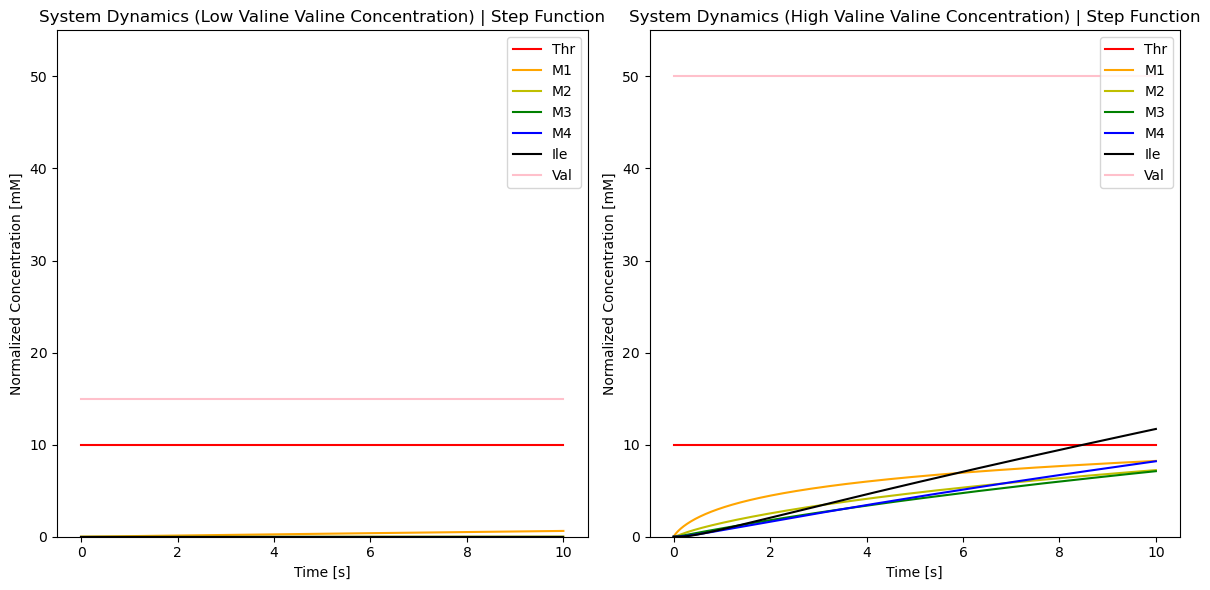

In [59]:
# Initial Conditions (Original concentration)
y0_low_valine = [10, 0, 0, 0, 0, 0, 15]
t = np.linspace(0, 10, 1000)
tspan = [t[0], t[-1]]
V_max_f_step = [10, 10, 10, 10, 10, 10]
V_max_r_step = [5, 5, 5, 5, 5, 5]
K_M_S_step = [1, 1, 1, 1, 1, 1]
K_M_P_step = [1, 1, 1, 1, 1, 1]
K_I_1 = [10000, 10000, 10000, 10000, 10000, 10000]
K_I_2 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
ode_sol_low_valine = solve_ivp(lambda t, y: EPI_dynamics_step(t, y, V_max_f_step, V_max_r_step, K_M_S_step, K_M_P_step, K_I_1, K_I_2), tspan, y0_low_valine, t_eval=t)

# Initial Conditions (High Valine)
y0_high_valine = [10, 0, 0, 0, 0, 0, 50]
tspan = [t[0], t[-1]]
ode_sol_high_valine = solve_ivp(lambda t, y: EPI_dynamics_step(t, y, V_max_f_step, V_max_r_step, K_M_S_step, K_M_P_step, K_I_1, K_I_2), tspan, y0_high_valine, t_eval=t)

# Calculate the maximum concentration value across both sets of data
max_concentration = max(np.max(ode_sol_low_valine.y), np.max(ode_sol_high_valine.y))

# Add a margin to the maximum concentration value to ensure the line for valine is still visible
margin = 5
max_concentration_sigmoid_with_margin = max_concentration_sigmoid + margin

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, sol, title in zip(axes, [ode_sol_low_valine, ode_sol_high_valine], ['Low Valine', 'High Valine']):
    ax.plot(t, sol.y[0], 'r', label="Thr")
    ax.plot(t, sol.y[1], 'orange', label="M1")
    ax.plot(t, sol.y[2], 'y', label="M2")
    ax.plot(t, sol.y[3], 'g', label="M3")
    ax.plot(t, sol.y[4], 'b', label="M4")
    ax.plot(t, sol.y[5], 'k', label="Ile")
    ax.plot(t, sol.y[6], 'pink', label="Val")
    ax.set_title(f'System Dynamics ({title} Valine Concentration) | Step Function')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Normalized Concentration [mM]')
    ax.legend(loc='upper right')
    ax.set_ylim(0, max_concentration_sigmoid_with_margin)  # Set y-axis limits to the maximum concentration value

plt.tight_layout()
plt.show()

The plots above show the dynamics of the isoleucine pathway when there is low valine concentration (left plot) compared to high valine concentration (rright plot). By comparing these plots, we see that when valine concentration is low, the isoleucine concentration remains low, deepicting the inhibition isoleucine causes on itself, without the valine concentration to reverse this inhibition present. However, when valine concentration is high, the isoleucine concentration is able to increase, depicting valine reversing the inhibition, which enables an increase in isoleucine concentration.

#### Inhibitor Constant Via Sigmoid Function
The following function models the isoleucine pathway dynamics when K_I is defined by a sigmoid function. In this model, the K_I parameter changes as a function of valine.

In [6]:
def EPI_dynamics_sigmoid(t,y,V_max_f_sig,V_max_r_sig,K_M_S_sig,K_M_P_sig,K_I_1, K_I_2, K_V):
    # y[0] = Thr L-threonine
    # y[1] = M1
    # y[2] = M2
    # y[3] = M3
    # y[4] = M4
    # y[5] = Ile Isoleucine
    # y[6] = Val Valine
    dydt = np.zeros(7)

    I = y[6] #Isoleucine as inhibitor
    
    # enzyme rate laws
    V = np.zeros(len(y)-1)
    # hard code first rxn
    S_1 = y[0]
    P_1 = y[1]
    V[0] = ((V_max_f_sig[0]/K_M_S_sig[0])*S_1-(V_max_r_sig[0]/K_M_P_sig[0])*P_1)/(1+S_1/K_M_S_sig[0]+P_1/K_M_P_sig[0]+I/10)
    for i in range(len(y)-1):
        S = y[i]
        P = y[i+1]
        K_I_sig = K_I_2 + (K_I_1[i] * y[6])/(K_V[i] + y[6])
        V[i] = ((V_max_f_sig[i]/K_M_S_sig[i])*S-(V_max_r_sig[i]/K_M_P_sig[i])*P)/(1+S/K_M_S_sig[i]+P/K_M_P_sig[i]+I/K_I_sig[i])

    #dydt[0] = -V[0] #dynamic substrate
    dydt[0] = 0 #fixed substrate
    dydt[1] = V[0]-V[1]
    dydt[2] = V[1]-V[2]
    dydt[3] = V[2]-V[3]
    dydt[4] = V[3]-V[4]
    dydt[5] = V[4]
    dydt[6] = 0 # valine is constant

    return dydt

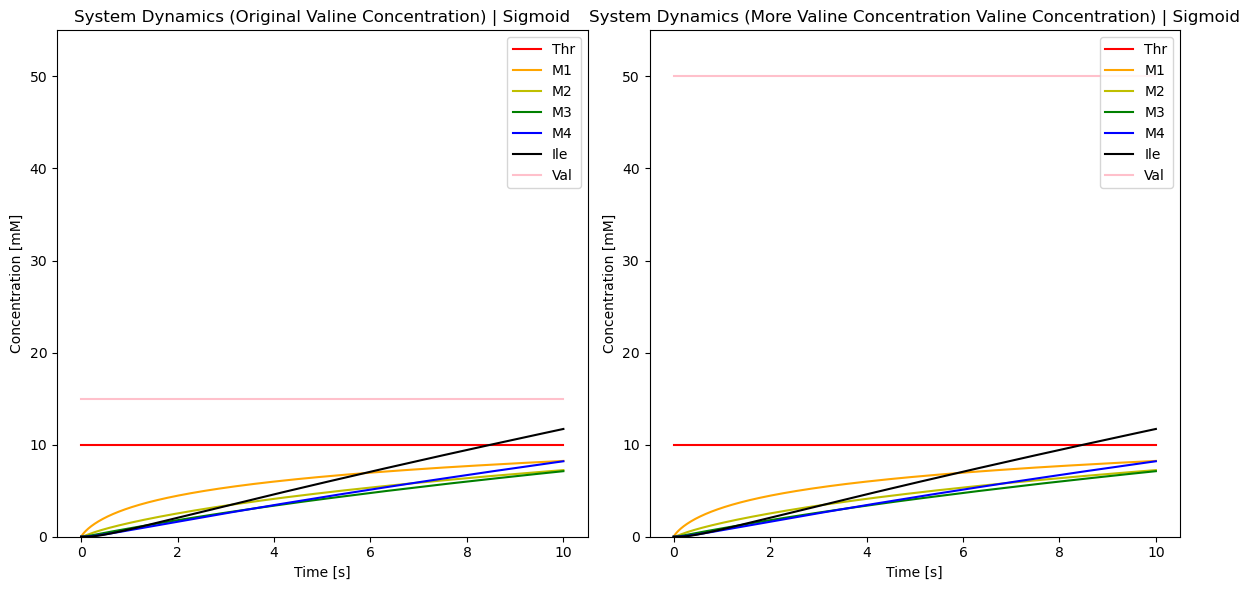

In [61]:
# Initial Conditions (original)
y0_original = [10, 0, 0, 0, 0, 0, 15]
t = np.linspace(0, 10, 1000)
tspan = [t[0], t[-1]]
V_max_f_sig = [10, 10, 10, 10, 10, 10]
V_max_r_sig = [5, 5, 5, 5, 5, 5]
K_M_S_sig = [1, 1, 1, 1, 1, 1]
K_M_P_sig = [1, 1, 1, 1, 1, 1]
K_I_1 = [10000, 10000, 10000, 10000, 10000, 10000]
K_I_2 = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
K_V_original = [40, 40, 40, 40, 40, 40, 40]
ode_sol_original = solve_ivp(lambda t, y: EPI_dynamics_sigmoid(t, y, V_max_f_sig, V_max_r_sig, K_M_S_sig, K_M_P_sig, K_I_1, K_I_2, K_V_original), tspan, y0_original, t_eval=t)

# Initial Conditions (more valine concentration)
y0_high_valine = [10, 0, 0, 0, 0, 0, 50]
tspan = [t[0], t[-1]]
K_V_high_valine = [1, 1, 1, 1, 1, 1, 1]
ode_sol_high_valine = solve_ivp(lambda t, y: EPI_dynamics_sigmoid(t, y, V_max_f_sig, V_max_r_sig, K_M_S_sig, K_M_P_sig, K_I_1, K_I_2, K_V_high_valine), tspan, y0_high_valine, t_eval=t)

# Calculate the maximum concentration value across both sets of data
max_concentration_sigmoid = max(np.max(ode_sol_original.y), np.max(ode_sol_high_valine.y))

# Add a margin to the maximum concentration value to ensure the line for valine is still visible
margin = 5
max_concentration_sigmoid_with_margin = max_concentration_sigmoid + margin

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, sol, title in zip(axes, [ode_sol_original, ode_sol_high_valine], ['Original', 'More Valine Concentration']):
    ax.plot(t, sol.y[0], 'r', label="Thr")
    ax.plot(t, sol.y[1], 'orange', label="M1")
    ax.plot(t, sol.y[2], 'y', label="M2")
    ax.plot(t, sol.y[3], 'g', label="M3")
    ax.plot(t, sol.y[4], 'b', label="M4")
    ax.plot(t, sol.y[5], 'k', label="Ile")
    ax.plot(t, sol.y[6], 'pink', label="Val")
    ax.set_title(f'System Dynamics ({title} Valine Concentration) | Sigmoid')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Concentration [mM]')
    ax.legend(loc='upper right')
    ax.set_ylim(0, max_concentration_sigmoid_with_margin)  # Set y-axis limits to the maximum concentration value

plt.tight_layout()
plt.show()

These plots show the isoleucine pathway dynamics when K_I is defined by a sigmoid function. In this model, the K_I parameteer changes as a function of valine. Like expected, since the sigmoid function did not have an effect on the reaction rate, depicted in the second graph, we can see that even with high or low concentration of valine, the concentration of isoleucine remaines the same. 

https://github.com/ichiulli/valine-on-isoleucine